In [2]:

import pandas as pd
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Load dataset
df = pd.read_csv('Ratings.csv')
df = df[df['Book-Rating'] > 0]  # remove zero ratings
df

,User-ID,ISBN,Book-Rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
6,276736,3257224281,8
7,276737,0600570967,6
...,...,...,...
1149773,276704,0806917695,5
1149775,276704,1563526298,9
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [4]:
df.duplicated().sum()

0

In [5]:

df['Book-Rating'].value_counts().sort_index()

Book-Rating
1       1770
2       2759
3       5996
4       8904
5      50974
6      36924
7      76457
8     103736
9      67541
10     78610
Name: count, dtype: int64

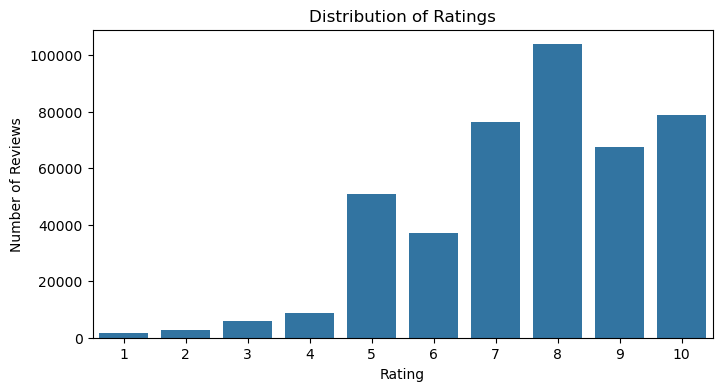

In [6]:
plt.figure(figsize=(8, 4))
sns.countplot(x="Book-Rating", data=df, order=sorted(df["Book-Rating"].unique()))
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")
plt.show()

In [7]:
book_counts = df['ISBN'].value_counts()

print("Unnique books:", df['ISBN'].nunique())
print("Total number of reviews:", len(df))


Unnique books: 185973
Total number of reviews: 433671


In [8]:
print(book_counts)

ISBN
0316666343     707
0971880107     581
0385504209     487
0312195516     383
0679781587     333
              ... 
0140441905       1
0886777267       1
0671697951       1
0553560956       1
05162443314      1
Name: count, Length: 185973, dtype: int64


In [9]:
book_counts.describe()

count    185973.000000
mean          2.331903
std           6.834667
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         707.000000
Name: count, dtype: float64

In [10]:
#Reviews per user
user_counts = df['User-ID'].value_counts()

In [11]:
user_counts.describe()

count    77805.000000
mean         5.573819
std         44.001879
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       8524.000000
Name: count, dtype: float64

In [12]:
#In item–item recommendations, each book should have at least a few reviews so that similarities can be calculated reliably.

#Below we investigate how many books and how many reviews are retained at different limits (1, 2, 4, 6, 8, 10 reviews per book).

thresholds = [1, 2, 4, 6, 8, 10]

results = {}

for t in thresholds:

    # Books with t>= reviews
    books_to_keep = book_counts[book_counts >= t].index

    # How many books remain
    num_books_remaining = len(books_to_keep)

    # Percentage of books remaining
    pct_books_remaining = 100 * num_books_remaining / df['ISBN'].nunique()

    # Filter the original dataframe to keep only reviews for those books
    df_tmp = df[df['ISBN'].isin(books_to_keep)]

    # How many reviews remain
    num_ratings_remaining = len(df_tmp)

    # Percentage of reviews remaining
    pct_ratings_remaining = 100 * num_ratings_remaining / len(df)

    # Save results
    results[t] = {
        "num_books_remaining": num_books_remaining,
        "pct_books_remaining": pct_books_remaining,
        "num_ratings_remaining": num_ratings_remaining,
        "pct_ratings_remaining": pct_ratings_remaining
    }

    results_df = pd.DataFrame(results).T

results_df["pct_books_remaining"] = results_df["pct_books_remaining"].round(2)
results_df["pct_ratings_remaining"] = results_df["pct_ratings_remaining"].round(2)

print("=== Results of Threshold Filtering ===")
display(results_df)



=== Results of Threshold Filtering ===


,num_books_remaining,pct_books_remaining,num_ratings_remaining,pct_ratings_remaining
1,185973.0,100.00,433671.0,100.00
2,56352.0,30.30,304050.0,70.11
4,19918.0,10.71,221009.0,50.96
6,11260.0,6.05,183102.0,42.22
8,7629.0,4.10,159819.0,36.85
10,5645.0,3.04,143110.0,33.00


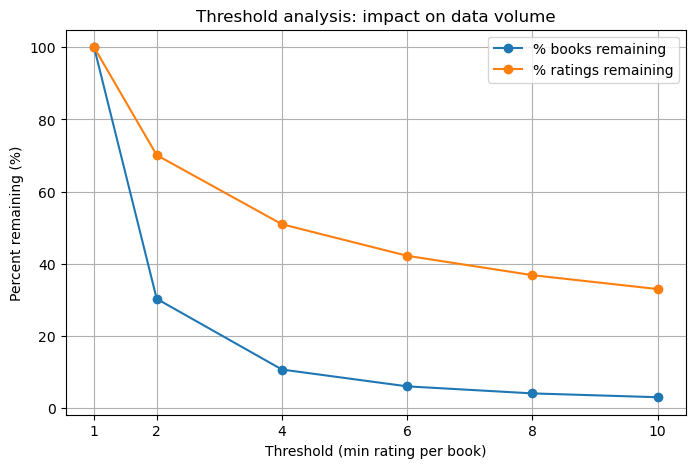

In [13]:
plt.figure(figsize=(8, 5))

plt.plot(results_df.index, results_df["pct_books_remaining"],
         marker="o", label="% books remaining")

plt.plot(results_df.index, results_df["pct_ratings_remaining"],
         marker="o", label="% ratings remaining")

plt.title("Threshold analysis: impact on data volume")
plt.xlabel("Threshold (min rating per book)")
plt.ylabel("Percent remaining (%)")

plt.xticks(results_df.index)
plt.grid(True)
plt.legend()
plt.show()

In [14]:
books_to_keep = book_counts[book_counts >= 3].index

df_filtered = df[df['ISBN'].isin(books_to_keep)].copy()

df_filtered["ISBN"] = (
    df_filtered["ISBN"]
        .astype(str)
        .str.strip()
        .str.upper()
)

print("Shape after filtering:", df_filtered.shape)

Shape after filtering: (251528, 3)


Rename the columns to the format that Surprise expects (user, item, rating)

In [15]:
df_filtered = df_filtered.rename(columns={
    'User-ID': 'user',
    'ISBN': 'item',
    'Book-Rating': 'rating'
})

df_filtered.head()

,user,item,rating
6,276736,3257224281,8
8,276744,038550120X,7
16,276747,0060517794,9
19,276747,0671537458,9
20,276747,0679776818,8


Verify/check the rating scale (minimum and maximum) so that Surprise can interpret the ratings correctly.

In [16]:
min_rating = df_filtered['rating'].min()
max_rating = df_filtered['rating'].max()

print(f"Rating scale: ", min_rating, "to", max_rating)

Rating scale:  1 to 10


The filtered data is loaded into the Surprise library's Dataset object.

In [17]:
from surprise import Dataset, Reader


reader = Reader(rating_scale=(min_rating, max_rating))

data = Dataset.load_from_df(
    df_filtered[['user', 'item', 'rating']],
    reader
)

80/20 train/test split, so the model can be evaluated on data it didn't see during training

In [18]:
from surprise.model_selection import train_test_split

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# 3. Item–item KNN-mallin koulutus

We train an item–item based KNNBasic model using cosine similarity. This corresponds to the typical "since you liked this, you will probably like these too" logic.

In [19]:
from surprise import KNNBasic

sim_options = {
    'name': 'cosine',
    'user_based': False  # False -> item-item similariteetti
}

algo = KNNBasic(sim_options=sim_options)

algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


# 4. Model evaluation

In [ ]:
# Evaluated with a test set
predictions = algo.test(testset)

predictions[:5]

[Prediction(uid=179330, iid='0060930535', r_ui=8.0, est=7.694357475822724, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=228703, iid='0395363179', r_ui=6.0, est=7.694357475822724, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=99312, iid='1562920448', r_ui=8.0, est=10, details={'actual_k': 3, 'was_impossible': False}),
 Prediction(uid=17183, iid='2207253465', r_ui=6.0, est=6.6, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid=88879, iid='0380898357', r_ui=10.0, est=7.694357475822724, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})]

In [21]:
from surprise import accuracy

# RMSE
rmse = accuracy.rmse(predictions)


# MAE
mae = accuracy.mae(predictions)

RMSE: 1.7828
MAE:  1.3386


In [22]:
pred_df = pd.DataFrame([
    {
        "user": pred.uid,
        "item": pred.iid,
        "true_rating": pred.r_ui,
        "predicted_rating": pred.est,
        "error": pred.est - pred.r_ui
    }
    for pred in predictions
])

pred_df.head()

,user,item,true_rating,predicted_rating,error
0,179330,0060930535,8.0,7.694357,-0.305643
1,228703,0395363179,6.0,7.694357,1.694357
2,99312,1562920448,8.0,10.000000,2.000000
3,17183,2207253465,6.0,6.600000,0.600000
4,88879,0380898357,10.0,7.694357,-2.305643


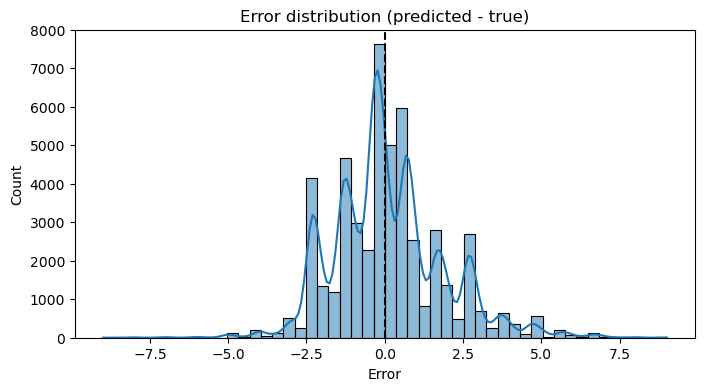

In [23]:
plt.figure(figsize=(8,4))
sns.histplot(pred_df["error"], bins=50, kde=True)
plt.title("Error distribution (predicted - true)")
plt.xlabel("Error")
plt.ylabel("Count")
plt.axvline(0, color='black', linestyle='--')
plt.show()

The error distribution is roughly symmetric around zero, which suggests that the model does not have strong systematic under- or overestimation.

Most of the errors are close to zero, but the distribution has wide tails: some predictions are off by several points.

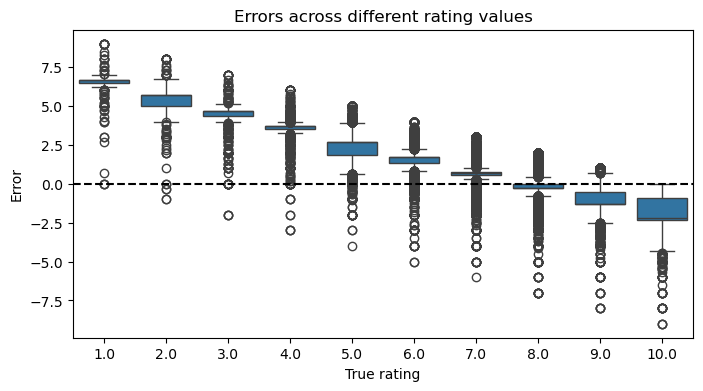

In [24]:
plt.figure(figsize=(8,4))
sns.boxplot(x="true_rating", y="error", data=pred_df)
plt.title("Errors across different rating values")
plt.xlabel("True rating")
plt.ylabel("Error")
plt.axhline(0, color='black', linestyle='--')
plt.show()

The boxplot shows how the errors are distributed with the actual rating values.

The model seems to overestimate the lowest ratings badly, but the estimates between 7 and 9 are relatively accurate.

# 5. Book data (Books.csv) and recommendation functions

We load Books.csv to get book titles and other metadata (e.g. author, year of publication). We then combine the predictions with the book data and build recommendation functions:

user-specific recommendations
similar books searched by book.
We import Books.csv to display the recommended book titles and other metadata.

In [25]:
books = pd.read_csv("Books.csv", dtype=str)
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


We will combine the predictions with Books.csv to include the book title and other information in the recommendations.

In [26]:
books['ISBN'] = (
    books['ISBN']
         .astype(str)
         .str.strip()
         .str.upper()
)

Recommend books to the user based on predicted ratings

In [27]:
def recommend_books_for_user(algo, df_filtered, books, user_id, n=10):
    # Kaikki ISBN datasetissä
    all_items = df_filtered['item'].unique()

    # Kirjat jotka käyttäjä on jo arvostellut
    rated_items = set(df_filtered[df_filtered['user'] == user_id]['item'])

    # Kirjat joita käyttäjä ei ole arvostellut
    items_to_predict = [iid for iid in all_items if iid not in rated_items]

    # Ennuste jokaiselle lopulle kirjalle
    predictions = [algo.predict(user_id, iid) for iid in items_to_predict]

    # Järjestetään suurimman arvioidun ratingin mukaan
    predictions.sort(key=lambda x: x.est, reverse=True)

    # Otetaan vain n parasta
    top_n = predictions[:n]

    # Muutetaan DataFrameksi
    recs = pd.DataFrame([{
        "ISBN": pred.iid,
        "predicted_rating": pred.est
    } for pred in top_n])

    recs = recs.merge(books, on="ISBN", how="left")

    # Poistetaan kirjat jotka eivät löytyneet Books.csv:stä
    recs = recs.dropna(subset=["Book-Title"])

    # Jos tulee NaN kirjoja luodaan ilmoitus
    recs['Book-Title'] = recs['Book-Title'].fillna("Kirjaa ei löytynyt metadatasta")

    return recs

In [28]:
result = recommend_books_for_user(algo, df_filtered, books, user_id="276737", n=4)
result

,ISBN,predicted_rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
1,038550120X,7.694357,A Painted House,JOHN GRISHAM,2001,Doubleday,http://images.amazon.com/images/P/038550120X.0...,http://images.amazon.com/images/P/038550120X.0...,http://images.amazon.com/images/P/038550120X.0...
2,0060517794,7.694357,Little Altars Everywhere,Rebecca Wells,2003,HarperTorch,http://images.amazon.com/images/P/0060517794.0...,http://images.amazon.com/images/P/0060517794.0...,http://images.amazon.com/images/P/0060517794.0...
3,0671537458,7.694357,Waiting to Exhale,Terry McMillan,1995,Pocket,http://images.amazon.com/images/P/0671537458.0...,http://images.amazon.com/images/P/0671537458.0...,http://images.amazon.com/images/P/0671537458.0...


Creating a book recommendation based on the book

In [29]:
# Function to search for books by name

def find_book_by_title(books, title):
    matches = books[books['Book-Title'].str.contains(title, case=False, na=False)]
    return matches

In [30]:
# Function for searching books using KNN model

def recommend_by_title(algo, books, title, n=10):
    # Etsitään kirjat, joiden nimessä esiintyy hakusana
    matches = find_book_by_title(books, title)
    
    if matches.empty:
        return f"Kirjan nimellä '{title}' ei löytynyt osumia."
    
    # Käytetään ensimmäistä osumaa
    target = matches.iloc[0]
    target_isbn = target['ISBN']
    
    print(f"Käytetään ISBN:ää {target_isbn} kirjalle '{target['Book-Title']}'")
    
    # Muutetaan ISBN Surprise-kirjaston sisäiseen ID-muotoon
    try:
        inner_id = algo.trainset.to_inner_iid(target_isbn)
    except:
        return "Tämä kirja ei ollut mukana koulutusdatassa, joten samankaltaisuuksia ei voida laskea."
    
    # Haetaan k lähintä naapuria (samankaltaisinta kirjaa)
    neighbors = algo.get_neighbors(inner_id, k=n)
    
    # Muutetaan sisäiset ID:t takaisin alkuperäisiksi ISBN-arvoiksi
    neighbor_isbns = [algo.trainset.to_raw_iid(inner_id) for inner_id in neighbors]
    
    # Palautetaan kirjat, joiden ISBN löytyy naapureista
    recs = books[books['ISBN'].isin(neighbor_isbns)]
    return recs

In [31]:
recommend_by_title(algo, books, "lord of the rings", n=3)

Käytetään ISBN:ää 8445071408 kirjalle 'El Senor De Los Anillos: LA Comunidad Del Anillo (Lord of the Rings (Spanish))'


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
231,0452282152,Girl with a Pearl Earring,Tracy Chevalier,2001,Plume Books,http://images.amazon.com/images/P/0452282152.0...,http://images.amazon.com/images/P/0452282152.0...,http://images.amazon.com/images/P/0452282152.0...
5570,8432055913,No Digas Que Fue UN Sueno: Marco Antonio Y Cle...,Terenci Moix,1986,Lectorum Pubns (J),http://images.amazon.com/images/P/8432055913.0...,http://images.amazon.com/images/P/8432055913.0...,http://images.amazon.com/images/P/8432055913.0...
12973,8478446400,Vendedor de Cuentos,Jostein Gaarder,2003,Siruela,http://images.amazon.com/images/P/8478446400.0...,http://images.amazon.com/images/P/8478446400.0...,http://images.amazon.com/images/P/8478446400.0...


In [32]:
def recommend_books_for_user(algo, df_filtered, books, user_id, n=10):
    # Kaikki ISBN datasetissä
    all_items = df_filtered['item'].unique()

    # Kirjat jotka käyttäjä on jo arvostellut
    rated_items = set(df_filtered[df_filtered['user'] == user_id]['item'])

    # Kirjat joita käyttäjä ei ole arvostellut
    items_to_predict = [iid for iid in all_items if iid not in rated_items]

    # Ennuste jokaiselle lopulle kirjalle
    predictions = [algo.predict(user_id, iid) for iid in items_to_predict]

    # Järjestetään suurimman arvioidun ratingin mukaan
    predictions.sort(key=lambda x: x.est, reverse=True)

    # Otetaan vain n parasta
    top_n = predictions[:n]

    # Muutetaan DataFrameksi
    recs = pd.DataFrame([{
        "ISBN": pred.iid,
        "predicted_rating": pred.est
    } for pred in top_n])

    recs = recs.merge(books, on="ISBN", how="left")

    # Poistetaan kirjat jotka eivät löytyneet Books.csv:stä
    recs = recs.dropna(subset=["Book-Title"])

    # Jos tulee NaN kirjoja luodaan ilmoitus
    recs['Book-Title'] = recs['Book-Title'].fillna("Kirjaa ei löytynyt metadatasta")


Users: 2977 Items: 733
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.6966


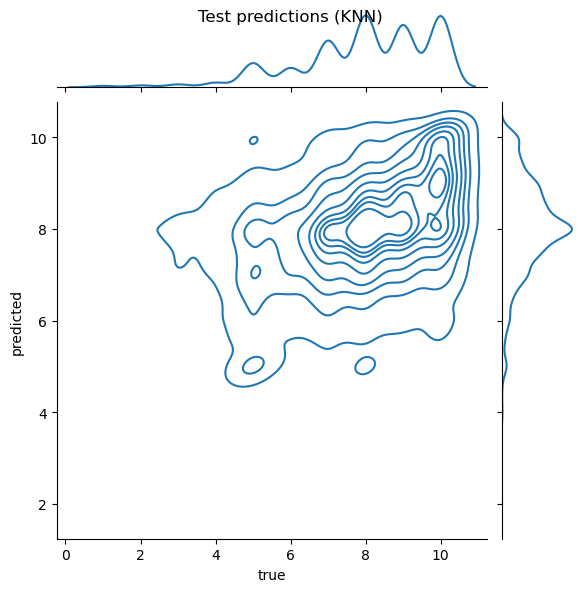

Top recommendations for User 277203: [('0439064864', 9.000000000000002), ('1558531025', 9.000000000000002), ('002542730X', 9.0), ('0061009059', 9.0), ('0385486804', 9.0)]
  Using cached nbconvert-7.16.6-py3-none-any.whl.metadata (8.5 kB)
  Using cached beautifulsoup4-4.14.3-py3-none-any.whl.metadata (3.8 kB)
  Using cached bleach-6.3.0-py3-none-any.whl.metadata (31 kB)
  Using cached defusedxml-0.7.1-py2.py3-none-any.whl.metadata (32 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached jupyterlab_pygments-0.3.0-py3-none-any.whl.metadata (4.4 kB)
  Using cached mistune-3.1.4-py3-none-any.whl.metadata (1.8 kB)
  Using cached nbclient-0.10.2-py3-none-any.whl.metadata (8.3 kB)
  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
  Using cached pandocfilters-1.5.1-py2.py3-none-any.whl.metadata (9.0 kB)
  Using cached webencodings-0.5.1-py2.py3-none-any.whl.metadata (2.1 kB)
  Using cached tinycss2-1.4.0-py3-none-any.whl.metadata (3.0 kB)
  Using cac

In [33]:
# Filter active users and popular items to reduce matrix size
user_counts = df['User-ID'].value_counts()
active_users = user_counts[user_counts > 20].index   # keep users with >20 ratings
df = df[df['User-ID'].isin(active_users)]
df

item_counts = df['ISBN'].value_counts()
popular_items = item_counts[item_counts > 20].index  # keep items with >20 ratings
df = df[df['ISBN'].isin(popular_items)]

print("Users:", df['User-ID'].nunique(), "Items:", df['ISBN'].nunique())
# Prepare Surprise dataset
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(df[['User-ID', 'ISBN', 'Book-Rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25)


# Train KNN model (limit neighbors to reduce memory)
sim_options = {
    'name': 'cosine',
    'user_based': False  # switch to False for item-based
}
algo = KNNBasic(k=40, sim_options=sim_options)  # k=40 keeps it manageable
algo.fit(trainset)

# Evaluate
predictions = algo.test(testset)
accuracy.rmse(predictions)

# Visualize predictions
true_ratings = [pred.r_ui for pred in predictions]
est_ratings = [pred.est for pred in predictions]
data_plot = pd.DataFrame({'true': true_ratings, 'predicted': est_ratings})
g = sns.jointplot(data=data_plot, x='true', y='predicted', kind='kde')
g.fig.suptitle('Test predictions (KNN)', fontsize=12)
plt.show()


# Recommend top N items for a user
def recommend_books(algo, df, user_id, n=5):
    all_items = df['ISBN'].unique()
    rated_items = df[df['User-ID'] == user_id]['ISBN'].unique()
    unrated_items = [item for item in all_items if item not in rated_items]

    predictions = [algo.predict(user_id, item) for item in unrated_items]
    top_n = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]
    return [(pred.iid, pred.est) for pred in top_n]

# Example: Recommend top 5 books for a sample user
sample_user = df['User-ID'].iloc[0]
recommendations = recommend_books(algo, df, sample_user, n=5)
print(f"Top recommendations for User {sample_user}:", recommendations)

!python -m pip install nbconvert

import nbformat
from nbconvert import HTMLExporter

# Load notebook
with open("book_reco.ipynb") as f:
    nb = nbformat.read(f, as_version=4)

# Convert to HTML
html_exporter = HTMLExporter()
(body, resources) = html_exporter.from_notebook_node(nb)

# Save HTML
with open("book_reco.html", "w", encoding="utf-8") as f:
    f.write(body)